In [1]:
import numpy as np
import timeit
import networkx as nx
import importlib.util
import matplotlib.pyplot as plt


import numpy.linalg as la
import scipy


# Funcion "Coordinate descent"

### Funciones auxiliares

In [27]:
def cost_function(A,X,M):
    """
    RDPG cost function ||(A-XX^T)*M||_F^2
    where * is the entry-wise product.

    Parameters
    ----------
    A : matrix nxn
    X : matrix of embeddings
    M : mask matrix nxn
        
    Returns
    -------
    value of ||(A-XX^T)*M||_F^2
    """
    return 0.5*np.linalg.norm((A - X@X.T)*M,ord='fro')**2

def solve_linear_system(A,b,xx):
    """
    Linear system solver, used in several methods.
    Should you use another method for solving linear systems, just change this function.
    
    Returns the solution of Ax=b
    Parameters
    ----------
    A : matrix nxn
    b : vector 

    Returns
    -------
    vector x
        solution to Ax=b

    """
    try:
        result = scipy.linalg.solve(A,b)
    except:
        result = scipy.sparse.linalg.minres(A,b,xx)[0]    
    return result

### Funcion principal

$min ||(A-XX^T)*M||_F^2$

In [26]:
def coordinate_descent(A,d,X=None,tol=1e-5):

    ## Modificado con los errores

    n=A.shape[0]
    M = np.ones(n) - np.eye(n)
    if X is None:
        X = np.random.rand(n,d)
    else:
        X = X.copy()
    
    R = X.T@X
    fold = -1

    errores = []

    iter = 0
    while (abs((fold - cost_function(A, X, M))/fold) >tol):

        fold = cost_function(A, X, M)
        for i in range(n):
            k=X[i,:][np.newaxis]  #(fila i)^t . (fila i)
            R -= k.T@k
            X[i,:] = solve_linear_system(R,(A[i,:]@X).T,X[i,:])
            k=X[i,:][np.newaxis]
            R += k.T@k
        err = abs((fold - cost_function(A, X, M))/fold)
        errores = errores + [err]
        print("Iteracion: " + str(iter) + " | Error relativo: " + str(err) + " | norma R: " + str(la.norm(R)))
        iter +=1
    return (X, errores)

### Ejemplo

In [28]:
gy=0
if importlib.util.find_spec('graspologic') is None:
    print("graspologic is not installed. Running the other methods.")
else:
    gy=1
    import graspologic as gy

##%%
def embed_scipy(A, K):
    UA, SA, VAt = scipy.linalg.svd(A)
    XA = UA[:,0:K].dot(np.diag(np.sqrt(SA[0:K])))    
    return XA

graspologic is not installed. Running the other methods.


In [29]:
p1 = [[0.5, 0.2],
      [0.2, 0.5]]
d=80
n_list = [1800, 1200]

nt=np.sum(n_list)
g = nx.stochastic_block_model(n_list,p1)
A_original = nx.to_numpy_array(g)
M_original = np.ones(nt) - np.eye(nt)
X_original = np.random.rand(A_original.shape[0],d)


Running Coordinate descent
Iteracion: 0 | Error relativo: 0.9993587639152381 | norma R: 820.7838397344846
Iteracion: 1 | Error relativo: 0.2202982195475419 | norma R: 1231.457354704782
Iteracion: 2 | Error relativo: 0.020307316761306347 | norma R: 1223.043659412023
Iteracion: 3 | Error relativo: 0.0065524517174043225 | norma R: 1224.4571459170697
Iteracion: 4 | Error relativo: 0.003486893224550271 | norma R: 1227.8575649669979
Iteracion: 5 | Error relativo: 0.002143251519924549 | norma R: 1229.7160212370725
Iteracion: 6 | Error relativo: 0.0014122257832418412 | norma R: 1230.7988037230825
Iteracion: 7 | Error relativo: 0.0009731095354040669 | norma R: 1231.5560948684442
Iteracion: 8 | Error relativo: 0.0006941238522181683 | norma R: 1232.0994902480584
Iteracion: 9 | Error relativo: 0.0005098018131667652 | norma R: 1232.4957839764986
Iteracion: 10 | Error relativo: 0.00038409331233431077 | norma R: 1232.7926971089869
Iteracion: 11 | Error relativo: 0.00029596366395248647 | norma R: 1233

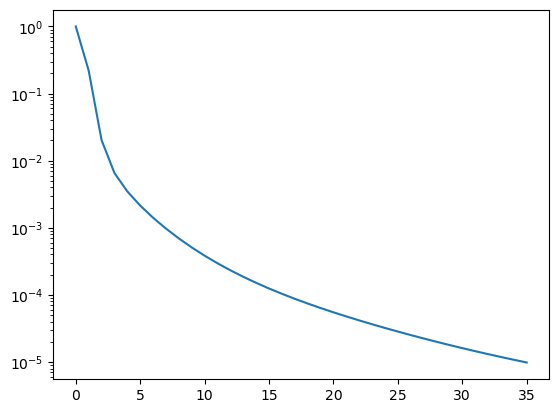

In [30]:
A = A_original.copy()
M = M_original.copy()
X = X_original.copy()

print("Running Coordinate descent")
start_cd = timeit.default_timer()
(X_cd, errores) = coordinate_descent(A,d)
stop_cd = timeit.default_timer()
time_cd = round(stop_cd-start_cd,3)
print("Done in ",time_cd," seconds.\n")

print("Running Scipy SVD")
start_scipy = timeit.default_timer()
X_scipy = embed_scipy(A,d)
stop_scipy = timeit.default_timer()
time_scipy = round(stop_scipy-start_scipy,3)
print("Done in ",time_scipy," seconds.\n")

if gy:
    print("Running Gaspologic ASE")
    ase = gy.embed.AdjacencySpectralEmbed(n_components=d, diag_aug=True, algorithm='full')
    start_gy = timeit.default_timer()
    X_gy = ase.fit_transform(A)
    stop_gy = timeit.default_timer()
    time_gy = round(stop_gy-start_gy,3)
    print("Done in ",time_gy," seconds.\n")

##%%
print("Method                        Time (s) \t Cost function ||(A-XX^T)*M||_F^2",)
print("---------------------------------------------------------------------",)
print("Coordinate descent            ",time_cd,"\t\t", cost_function(A,X_cd,M))
print("Scipy                         ",time_scipy,"\t\t", cost_function(A,X_scipy,M))
if gy: print("Graspologic                   ",time_gy,"\t\t", cost_function(A,X_gy,M))

plt.plot(errores)
plt.yscale('log')
x_star = X_cd

### Tercera idea

Luego de la reunion con Ernesto el 18/4, se propuso la idea de intentar ver si varios hilos calculan cada iteracion utilizando como regiones criticas la actualizacion de R.

En mi opinion tambien se deberia poner la linea " X[i,:] = solve_linear_system(R,(A[i,:]@X).T,X[i,:]) " como zona critica, ya que se consume R, pero en caso de hacer eso no tiene sentido papralelizar.

IMPORTANTE: Probe sin el mutex y tambien funciona, no entiendo muy bien como.



In [3]:
import threading

## Implementamos el metodo, utilizando varios hilos

In [23]:

lock_R = threading.Lock()

def coordinate_descent_MODIFICADO_3_per_thread(i, seriales):
    global X
    global R
    global A
    global finish
    global barrier_descent
    
    while not finish:     
        
        if seriales:
            with lock_R as l:
                k=X[i,:][np.newaxis]  #(fila i)^t . (fila i)
                R -= k.T@k
                sol = solve_linear_system(R,(A[i,:]@X).T,X[i,:])
            
                X[i,:] = sol
                k=X[i,:][np.newaxis]
            
                R += k.T@k
            barrier_descent.wait()

        else:
            k=X[i,:][np.newaxis]  #(fila i)^t . (fila i)
            R -= k.T@k
            sol = solve_linear_system(R,(A[i,:]@X).T,X[i,:])
        
            X[i,:] = sol
            k=X[i,:][np.newaxis]
        
            R += k.T@k
            barrier_descent.wait()
    

def update_finish_descent(max_iteraciones, tolerancia):
    def ineer_update():
        global finish 
        global fold
        global err_current_iteracion_decent
        global X
        global R
        global A
        global M
        global iter
        
        finish = not ((max_iteraciones is None or iter < max_iteraciones) and abs((fold - cost_function(A, X, M)) / fold) > tolerancia)
        err_current_iteracion_decent = abs((fold - cost_function(A, X, M))/fold)
        fold = cost_function(A, X, M)
        
    
    return  ineer_update


def coordinate_descent_MODIFICADO_3(max_iteraciones, calculoSerial=False, tol=1e-5):
    global X
    global R
    global A

    global lock_R
    lock_R = threading.Lock()

    n=A.shape[0]
    M = np.ones(n) - np.eye(n)
    R = X.T@X
    
    global fold
    fold = -1
    
    global barrier_descent
    barrier_descent = threading.Barrier(n + 1, action=update_finish_descent(max_iteraciones, tol))

    errores = []
    
    global finish
    finish = False
    
    ths = []
    for i in range(n):
        ths.append(threading.Thread(target = coordinate_descent_MODIFICADO_3_per_thread, args = (i,calculoSerial,)))

    for i in range(n):            
        ths[i].start()    

    global err_current_iteracion_decent
    err_current_iteracion_decent = 0


    global iter
    iter = 0
    while not finish:            
        barrier_descent.wait()
           
        errores.append(err_current_iteracion_decent)
        iter +=1
        print("Iteracion: " + str(iter) + " | Error: " + str(err_current_iteracion_decent) + " | norma R: " + str(la.norm(R)))

    return (X, errores)

#### Llamada al metodo, utilizando calculo paralelo (Maximo 51 iteraciones)

Running Coordinate descent Modificado 3
Iteracion: 1 | Error: 1120505.991680267 | norma R: 614.9728376142538
Iteracion: 2 | Error: 2.085490141108943 | norma R: 1212.961618437866
Iteracion: 3 | Error: 5.209377747389842 | norma R: 6876.157795472736
Iteracion: 4 | Error: 4.095768685414339 | norma R: 11039.35066668524
Iteracion: 5 | Error: 0.6896408298650576 | norma R: 3359.8579004728927
Iteracion: 6 | Error: 0.7603839850650769 | norma R: 4284.04139382916
Iteracion: 7 | Error: 2.8516873688059166 | norma R: 6501.535071514837
Iteracion: 8 | Error: 0.5606041636030464 | norma R: 5590.163081681298
Iteracion: 9 | Error: 0.21138574894047427 | norma R: 3580.7119557571527
Iteracion: 10 | Error: 1.882099746788928 | norma R: 3595.7559450793174
Iteracion: 11 | Error: 0.1485220022570124 | norma R: 7614.220060282272
Iteracion: 12 | Error: 0.572385089210339 | norma R: 4236.7884722698545
Iteracion: 13 | Error: 0.5642303108183251 | norma R: 978.4204463963238
Iteracion: 14 | Error: 0.42095960871878163 | nor

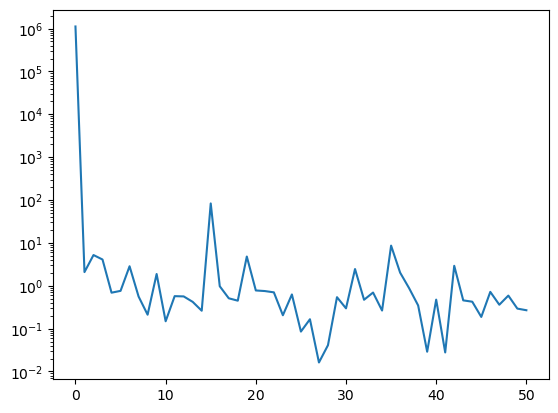

In [18]:

nt=np.sum(n_list)

A = A_original.copy()
M = M_original.copy()
X = X_original.copy()

print("Running Coordinate descent Modificado 3 (PARALELO)")
start_cd = timeit.default_timer()
(X_cd_S, errores) = coordinate_descent_MODIFICADO_3(50)
stop_cd = timeit.default_timer()
time_cd = round(stop_cd-start_cd,3)
print("Done in ",time_cd," seconds.\n")

plt.plot(errores)
plt.yscale('log')
plt.show()

#### Llamada al metodo, NO paralelo

Running Coordinate descent Modificado 3 (SERIAL)
Iteracion: 1 | Error: 1136278.7651604614 | norma R: 803.3189018612802
Iteracion: 2 | Error: 0.2266469806301112 | norma R: 1247.9968849234333
Iteracion: 3 | Error: 0.021926742422922748 | norma R: 1220.7340602398551
Iteracion: 4 | Error: 0.006691470731023458 | norma R: 1225.0094256860586
Iteracion: 5 | Error: 0.0037518092539354426 | norma R: 1228.5713548753022
Iteracion: 6 | Error: 0.0022902309466803733 | norma R: 1230.0315647785617
Iteracion: 7 | Error: 0.0015246476346859245 | norma R: 1231.1505012625178
Iteracion: 8 | Error: 0.0010683321794440293 | norma R: 1231.947961966095
Iteracion: 9 | Error: 0.000774220729484987 | norma R: 1232.4848489834385
Iteracion: 10 | Error: 0.0005606422553272001 | norma R: 1232.4591785706414
Iteracion: 11 | Error: 0.00040572954143861716 | norma R: 1233.1063623129394
Iteracion: 12 | Error: 0.0003425040877508262 | norma R: 1233.3928427647024
Iteracion: 13 | Error: 0.0002743061097457088 | norma R: 1233.585712463

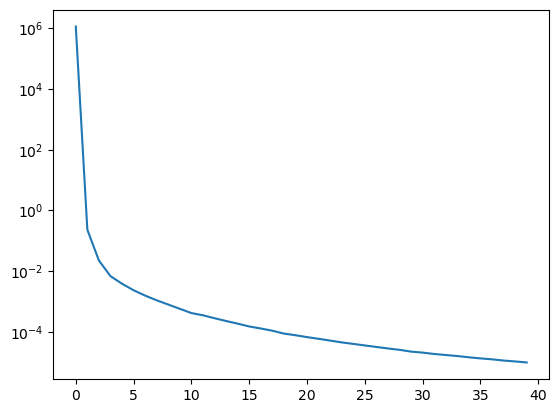

In [24]:
nt=np.sum(n_list)

A = A_original.copy()
M = M_original.copy()
X = X_original.copy()

g = nx.stochastic_block_model(n_list,p1)


print("Running Coordinate descent Modificado 3 (SERIAL)")
start_cd = timeit.default_timer()
(X_cd_S, errores) = coordinate_descent_MODIFICADO_3(50, True)
stop_cd = timeit.default_timer()
time_cd = round(stop_cd-start_cd,3)
print("Done in ",time_cd," seconds.\n")

plt.plot(errores)
plt.yscale('log')
plt.show()